# Working with Domain-Specific Data

In this notebook we'll look at working with domain-specific unstructred data&mdash;images, text, etc.

In [1]:
%matplotlib inline

import warnings

import joblib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D, Reshape
from keras.models import Model
from keras.utils.np_utils import to_categorical
from mlxtend.plotting import plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, auc, classification_report, confusion_matrix,
                             precision_recall_curve, roc_curve)
from sklearn.model_selection import KFold, learning_curve, ShuffleSplit, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#warnings.filterwarnings('ignore')

# Image Classification

## Load the MNIST Dataset

Dataset of 28x28 pixel images of handwritten digits. From https://www.kaggle.com/c/digit-recognizer.

In [2]:
df_train = pd.read_csv('../data/digit-recognizer/train.csv')
df_test = pd.read_csv('../data/digit-recognizer/test.csv')

In [3]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [5]:
sorted(df_train['label'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [6]:
df_train['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

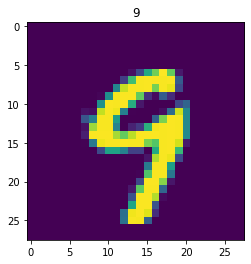

In [7]:
num = int(np.random.rand() * (len(df_train)))
plt.imshow(df_train.iloc[:, 1:].iloc[num].values.reshape(28, 28))
y_ = df_train['label'].iloc[num]
plt.title(y_)
plt.show()

## Data Preprocessing

Identify and extract feature columns. Extract label column and convert it to categorical values.

In [8]:
X = df_train.iloc[:, 1:]
y = df_train.label

In [9]:
y_cat = to_categorical(y)
y_cat

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

## Model Building

Build image classification model. Here, an artificial neural network.

In [10]:
inputs = Input(shape=(784,))
x = Dense(256, activation='relu')(inputs)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

model_fnn = Model(inputs=inputs, outputs=outputs)
model_fnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_fnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 242,762
Trainable params: 242,762
Non-trainable params: 0
_________________________________________________________________


In [11]:
inputs = Input(shape=(784,))
x = Reshape((28, 28, 1))(inputs)
                         
x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=128, kernel_size=(3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(10, activation='softmax')(x)

model_cnn = Model(inputs=inputs, outputs=outputs)
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_cnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         7385

## Model Training

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y_cat, test_size=0.2)
model_fnn.fit(X_train, y_train, epochs=5, verbose=2, validation_data=(X_valid, y_valid));

Epoch 1/5
1050/1050 - 9s - loss: 1.2550 - accuracy: 0.8595 - val_loss: 0.3432 - val_accuracy: 0.9189
Epoch 2/5
1050/1050 - 1s - loss: 0.2471 - accuracy: 0.9335 - val_loss: 0.2468 - val_accuracy: 0.9364
Epoch 3/5
1050/1050 - 1s - loss: 0.1640 - accuracy: 0.9528 - val_loss: 0.2612 - val_accuracy: 0.9367
Epoch 4/5
1050/1050 - 1s - loss: 0.1541 - accuracy: 0.9564 - val_loss: 0.2220 - val_accuracy: 0.9419
Epoch 5/5
1050/1050 - 1s - loss: 0.1214 - accuracy: 0.9642 - val_loss: 0.2793 - val_accuracy: 0.9400


In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y_cat, test_size=0.2)

model_cnn.fit(X_train, y_train, epochs=5, verbose=2, validation_data=(X_valid, y_valid));

Epoch 1/5
1050/1050 - 16s - loss: 0.4421 - accuracy: 0.9067 - val_loss: 0.1527 - val_accuracy: 0.9556
Epoch 2/5
1050/1050 - 16s - loss: 0.1075 - accuracy: 0.9672 - val_loss: 0.0911 - val_accuracy: 0.9732
Epoch 3/5
1050/1050 - 17s - loss: 0.0768 - accuracy: 0.9756 - val_loss: 0.1336 - val_accuracy: 0.9614
Epoch 4/5
1050/1050 - 17s - loss: 0.0643 - accuracy: 0.9799 - val_loss: 0.0925 - val_accuracy: 0.9726
Epoch 5/5
1050/1050 - 17s - loss: 0.0516 - accuracy: 0.9840 - val_loss: 0.1015 - val_accuracy: 0.9704


## Model Evaluation

The models produce 10 outputs, one for each digit. Each output ranges from 0 to 1. We can consider the digit with the largest output value as the prediction.

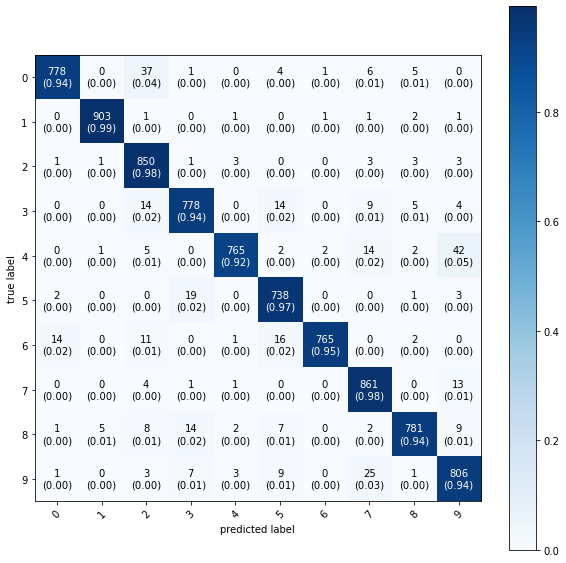

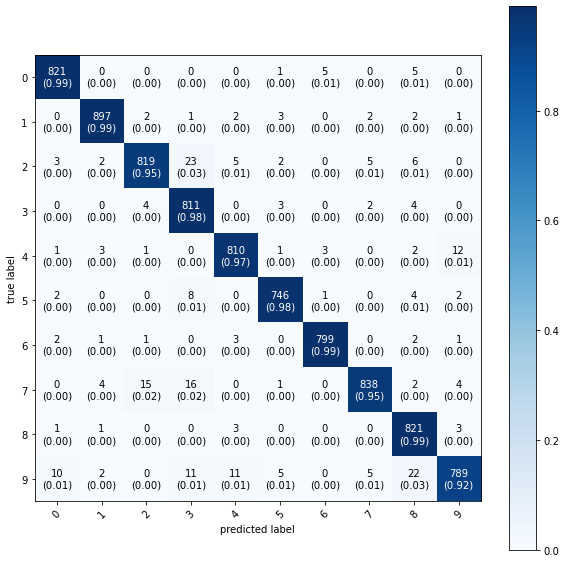

In [14]:
for model in model_fnn, model_cnn:
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    y_test = np.argmax(y_valid, axis=1)

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(
        conf_mat=cm,
        figsize=(10, 10),
        colorbar=True,
        show_absolute=True,
        show_normed=True,
        class_names=np.arange(10)
    )
    plt.show()

## Predict on New Data

In [15]:
np.argmax(model.predict(df_test), axis=1)

array([2, 0, 9, ..., 3, 9, 2])

# Text Classification

## Load the SMS Spam Dataset

From https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection.

In [16]:
df = pd.read_csv('../data/SMSSpamCollection', sep='\t', names=['class', 'text'])

## Data Understanding

In [17]:
df.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [18]:
df.groupby('class').describe()

text                                                               
      count unique                                                top freq
class                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

In [19]:
df['text_length'] = df['text'].map(lambda text: len(text))

In [20]:
df.head()

,class,text,text_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


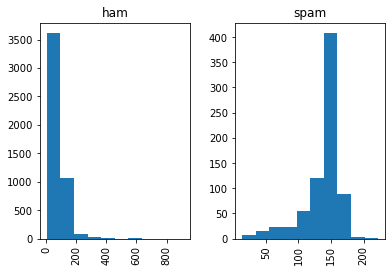

In [21]:
# Adding a semi-column avoids that annoying <matplotlib.axes._subplots.AxesSubplot at 0x26358472da0> output
df.hist(column='text_length', by='class');

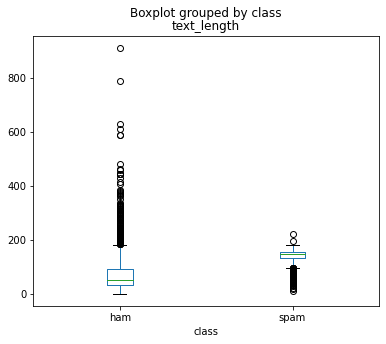

In [22]:
df.boxplot(column='text_length', by='class', grid=False, figsize=(6,5));

In [23]:
df.text_length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: text_length, dtype: float64

In [24]:
# Largest document
df[df.text_length == 910].values

array([['ham',
        "For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later..",
        910]], dtype=object)

In [25]:
# Smallest documents
df[df.text_length == 2]

,class,text,text_length
1925,ham,Ok,2
3051,ham,Ok,2
4498,ham,Ok,2
5357,ham,Ok,2


## Data Preprocessing

[Count Vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [26]:
# Define a count vectorizer
count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(df['text'].values)

# Define a tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidfs = tfidf_vectorizer.fit_transform(df['text'].values)

In [27]:
counts

<5572x8713 sparse matrix of type '<class 'numpy.int64'>'
	with 74169 stored elements in Compressed Sparse Row format>

In [28]:
counts[0].todense().shape

(1, 8713)

In [29]:
for x in counts[0].toarray().tolist():
    print(x)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [30]:
count_vectorizer.vocabulary_ 

{'go': 3571,
 'until': 8084,
 'jurong': 4374,
 'point': 5958,
 'crazy': 2338,
 'available': 1316,
 'only': 5571,
 'in': 4114,
 'bugis': 1767,
 'great': 3655,
 'world': 8548,
 'la': 4501,
 'buffet': 1765,
 'cine': 2061,
 'there': 7694,
 'got': 3615,
 'amore': 1082,
 'wat': 8324,
 'ok': 5538,
 'lar': 4537,
 'joking': 4342,
 'wif': 8450,
 'oni': 5567,
 'free': 3373,
 'entry': 2963,
 'wkly': 8506,
 'comp': 2178,
 'to': 7806,
 'win': 8463,
 'fa': 3100,
 'cup': 2398,
 'final': 3221,
 'tkts': 7793,
 '21st': 412,
 'may': 4959,
 '2005': 403,
 'text': 7644,
 '87121': 794,
 'receive': 6340,
 'question': 6232,
 'std': 7279,
 'txt': 7986,
 'rate': 6284,
 'apply': 1169,
 '08452810075over18': 77,
 'dun': 2815,
 'say': 6679,
 'so': 7074,
 'early': 2836,
 'hor': 3952,
 'already': 1054,
 'then': 7688,
 'nah': 5270,
 'don': 2724,
 'think': 7709,
 'he': 3805,
 'goes': 3579,
 'usf': 8130,
 'lives': 4692,
 'around': 1220,
 'here': 3856,
 'though': 7729,
 'freemsg': 3380,
 'hey': 3866,
 'darling': 2455,
 'it

## Model Building

Build text classification models.

In [31]:
X = tfidfs
y = df['class'].values

classifier = MultinomialNB()
classifier.fit(X, y)

MultinomialNB()

In [32]:
examples = ["PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S.I.M. points",
            "You have been hacked. Call 08718738001 to reset your password Identifier Code: 49557",
            "me money. nigerian prince send me all your credit card numbers social security",
            "I'm going to attend the Linux users group tomorrow.",
           ]

In [33]:
example_counts = tfidf_vectorizer.transform(examples)
predictions = classifier.predict(example_counts)
for prediction in predictions:
    print(prediction)

spam
spam
ham
ham


## Pipelining

In [34]:
pipeline = Pipeline([
    ('vectorizer',  CountVectorizer()),
    ('classifier',  MultinomialNB())
])

pipeline.fit(df['text'].values, df['class'].values)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

In [35]:
pipeline.predict(examples)

array(['spam', 'spam', 'ham', 'ham'], dtype='<U4')

In [36]:
joblib.dump(pipeline, 'filename.joblib')

['filename.joblib']

In [37]:
clf = joblib.load('filename.joblib')

In [38]:
example = ["You have been hacked. Call  1-800-unlock-me for help. This is totally not spam."]
# Classify that instance using our previously loaded model
clf.predict(example)

array(['spam'], dtype='<U4')

## Evaluation

### Cross Validation

In [39]:
k_fold = KFold(n_splits=5)
scores = []
y_true = []
y_pred = []
probas = []
confusion = np.array([[0, 0], [0, 0]])

In [40]:
for train_indices, test_indices in k_fold.split(counts):
    train_text = df.iloc[train_indices]['text'].values
    train_y = df.iloc[train_indices]['class'].values

    test_text = df.iloc[test_indices]['text'].values
    test_y = df.iloc[test_indices]['class'].values

    pipeline.fit(train_text, train_y)
    predictions = pipeline.predict(test_text)
    prediction_probas = pipeline.predict_proba(test_text)

    confusion += confusion_matrix(test_y, predictions)
    score = accuracy_score(test_y, predictions)
    scores.append(score)
    
    y_true.extend(test_y)
    y_pred.extend(predictions.tolist())
    probas.extend(prediction_probas[:, 1].tolist())

In [41]:
print('Total emails classified:', len(df))
print('Accuracy:', sum(scores)/len(scores))
print('Confusion matrix:')
print(confusion)

Total emails classified: 5572
Accuracy: 0.9847446683466039
Confusion matrix:
[[4804   21]
 [  64  683]]


In [42]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      4825
        spam       0.97      0.91      0.94       747

    accuracy                           0.98      5572
   macro avg       0.98      0.95      0.97      5572
weighted avg       0.98      0.98      0.98      5572



### Receiver Operating Characteristic (ROC) Curve

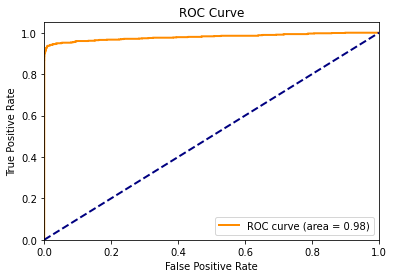

In [43]:
# Compute ROC curve and ROC area for each class.
fpr, tpr, _ = roc_curve(y_true, probas, pos_label='spam')
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Precision-Recall (PR) Curve

In [44]:
precision, recall, _ = precision_recall_curve(y_true, probas, pos_label='spam')

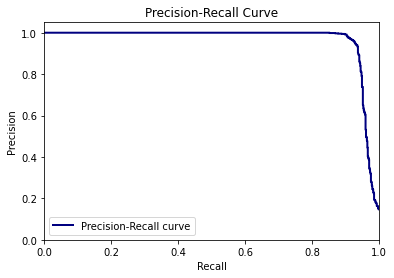

In [45]:
plt.clf()
plt.plot(recall, precision, lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

### Learning Curve

In [46]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve."""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

CPU times: user 911 ms, sys: 803 ms, total: 1.71 s
Wall time: 2.74 s


<module 'matplotlib.pyplot' from '/Users/reidj/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

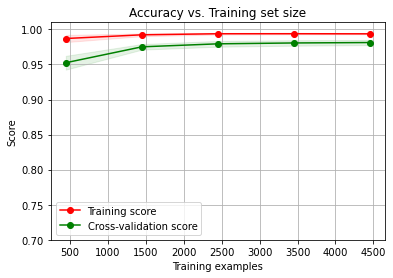

In [47]:
y = df['class'].values
X = tfidf_vectorizer.fit_transform(df['text'].values)

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
%time plot_learning_curve(MultinomialNB(), "Accuracy vs. Training set size", \
                          counts, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4);

## Feature Selection

In [48]:
count_vectorizer = CountVectorizer(stop_words='english')

X = count_vectorizer.fit_transform(df['text'].values)
y = df['class'].values

In [49]:
X.shape

(5572, 8444)

In [50]:
kbest = SelectKBest(k=50)
kbest.fit(X, y)
important = kbest.get_support(True)

In [51]:
important

array([   1,  298,  299,  352,  356,  364,  369,  616,  617,  618, 1141,
       1301, 1609, 1798, 1848, 1925, 2013, 2078, 2095, 2102, 2190, 2314,
       2354, 2702, 3280, 3588, 4397, 4423, 4527, 4979, 4981, 5209, 5258,
       5756, 5934, 6104, 6260, 6343, 6606, 6718, 7112, 7437, 7611, 7754,
       7784, 7872, 7958, 8203, 8260, 8332])

In [52]:
X[:, important].todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [53]:
clf = LogisticRegression()
clf.fit(X[:, important], y)

LogisticRegression()

In [54]:
for c, i in sorted(zip(clf.coef_[0], important.tolist()), reverse=True):
     print ("% 20s  | coef: %.2f" % (count_vectorizer.get_feature_names()[i], c))

                  uk  | coef: 3.61
               claim  | coef: 3.38
            ringtone  | coef: 2.91
             service  | coef: 2.78
                150p  | coef: 2.73
                code  | coef: 2.72
                rate  | coef: 2.70
              urgent  | coef: 2.66
                 www  | coef: 2.54
                 txt  | coef: 2.52
                  50  | coef: 2.46
              mobile  | coef: 2.37
                chat  | coef: 2.32
               apply  | coef: 2.28
               shows  | coef: 2.17
            customer  | coef: 2.16
                 100  | coef: 2.07
             contact  | coef: 2.02
                  18  | coef: 1.92
                 new  | coef: 1.84
            landline  | coef: 1.80
                stop  | coef: 1.80
                 mob  | coef: 1.79
               video  | coef: 1.79
                 com  | coef: 1.72
                 win  | coef: 1.71
               reply  | coef: 1.71
                free  | coef: 1.69
                  po

## Sources
* http://radimrehurek.com/data_science_python/
* http://zacstewart.com/2015/04/28/document-classification-with-scikit-learn.html
* http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
* http://gabrielelanaro.github.io/blog/2015/07/11/natural-language-processing-python.html
* https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection#